# Titanic

Algunas de los aspectos que se realizarán son:

* Ver el número de valores nulos
* Representar el porcentaje de filas con atributos nulos.
* Limpieza de columnas.
* Saber la edad mínima y máxima de las personas del barco.
* Conocer la mediana de las edades.
* Ver los precios (columna `fares`) más altos y bajos.
* Número de pasajeros embarcados (columna `Embarked`).
* Ver la distribución de sexos en las personas embarcadas.

##### VARIABLES
<table>
  <tr>
    <th>Nombre de la columna</th>
    <th>Descripción</th>
  </tr>
  <tr>
    <td>PassengerId</td>
    <td>Identificador del pasajero. Único por cada pasajero.</td>
  </tr>
  <tr>
    <td>Survived</td>
    <td>Indica 1 si el pasajero sobrevivió al naufragio, 0 si no sobrevivió.</td>
  </tr>
  <tr>
    <td>Pclass</td>
    <td>Clase a la que pertenecía el pasajero: 1, 2 o 3.</td>
  </tr>
  <tr>
    <td>Name</td>
    <td>Nombre del pasajero.</td>
  </tr>
  <tr>
    <td>Sex</td>
    <td>Sexo biológico del pasajero.</td>
  </tr>
  <tr>
    <td>Age</td>
    <td>Edad del pasajero.</td>
  </tr>
  <tr>
    <td>SibSp</td>
    <td>Número de hermanos, hermanas, hermanastros o hermanastras en el barco.</td>
  </tr>
  <tr>
    <td>Parch</td>
    <td> Número de padres e hijos en el barco. </td>
  </tr>
  <tr>
    <td>Ticket</td>
    <td>Identificador del billete.</td>
  </tr>
  <tr>
    <td>Fare</td>
    <td>Precio pagado por el billete.</td>
  </tr>
    <tr>
    <td>Cabin</td>
    <td>Identificador del camarote asignado al pasajero.</td>
  </tr>
  <tr>
    <td>Embarked</td>
    <td>Puerto en el que embarcó el pasajero.</td>
  </tr>
</table>


## 1. Importamos librerías y los datos


### 1.1 Librerías

In [188]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from fast_ml import eda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

### 1.2 Importación de los datos

In [121]:
datos = pd.read_csv(r'C:\Users\danyr\Documents\GitHub\Titanic\titanic.csv')

### 1.3 Análisis de las estructura de los datos:
Tres formas diferentes de visualizar la estructura general de los datos.

* Una forma más genérica de ver el tipo de datos y el número de entradas para cada variable

In [122]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Estadística descriptiva de las variables numéricas

In [123]:
# Lo hacemos seleccionado estas variables en concreto, 
#porque las otras variables que también son numéricas, realmente son variables categóricas codificadas.
datos[['Fare','Age']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000


* resumen o análisis exploratorio de los datos. Información sobre el tipo de datos, valores faltantes, estadísticas descriptivas.

In [124]:
eda.df_info(datos)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
PassengerId,int64,Numerical,891,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,0.0
Survived,int64,Numerical,2,"[0, 1]",0,0.0
Pclass,int64,Numerical,3,"[3, 1, 2]",0,0.0
Name,object,Categorical,891,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",0,0.0
Sex,object,Categorical,2,"[male, female]",0,0.0
Age,float64,Numerical,88,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",177,19.86532
SibSp,int64,Numerical,7,"[1, 0, 3, 4, 2, 5, 8]",0,0.0
Parch,int64,Numerical,7,"[0, 1, 2, 5, 3, 4, 6]",0,0.0
Ticket,object,Categorical,681,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",0,0.0
Fare,float64,Numerical,248,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",0,0.0


### 1.4 Valores nulos:

* Vemos que los valores nulos que tenemos están en Cabin, Age y Embarked. 
    * Embarked: son muy pocos nulos no afecta
    * Cabin: es una variable que es muy complicada predecir y hay muy pocos valores conocidos.
    * Age los imputaremos con KNNRegression más adelante.

In [125]:
#Valores nulos
missing_data = datos.isnull().sum(axis = 0) 
missing_data = missing_data[missing_data>0] 
missing_data.sort_values(ascending = False) 


Cabin       687
Age         177
Embarked      2
dtype: int64

In [126]:
moda = datos['Embarked'].mode()[0]
datos['Embarked'] = datos['Embarked'].fillna(moda)

* Representación gráfica del porcentaje de valores nulos:

In [127]:
# Porcentaje de filas con valores nulos.
filas = len(datos) #Número total de filas
filas_null = datos.isnull().any(axis=1).sum() # Número de filas con valores nulos
filas_sin_null = filas - filas_null #Numero de filas sin valores nulos

porcentajes = pd.DataFrame({'Tipo': ['Con valores nulos', 'Sin valores nulos'],
                               'Cantidad': [filas_null, filas_sin_null]}) # dataframe con las cantidades de filas con nulos y sin nulos.

#Representación gráfica
fig1 = px.pie(porcentajes, names='Tipo', values='Cantidad', title='Porcentaje de filas con NaN Original',
             width= 600,
             color_discrete_sequence=px.colors.sequential.Blues_r)

fig1.show()


## 2. Limpieza de datos:

In [128]:
#Creamos una copia del dataframe datos, para poder modificarlo sin afectar al original.
df = datos.copy() 
# Creación de una columna nueva para el apellido.
df['LastName'] = df['Name'].apply(lambda x : x.split(',')[0])

### 2.1 Vamos a tratar los valores nulos en 'Age' con el método de KNN:

In [129]:
#Eliminamos los decimales de la columna 'Age' 
df['Age'] = df['Age']//1
df[df['Age']<1]['Age']

78     0.0
305    0.0
469    0.0
644    0.0
755    0.0
803    0.0
831    0.0
Name: Age, dtype: float64

In [130]:
#Se estandariza la columna 'Fare' para que no tenga un impacto desproporcionado en la distancia 
scaler = StandardScaler()
df['Fare'] = scaler.fit_transform(df[['Fare']])

In [131]:
#Se especifican las columnas que se usarán como predictores y se transforman en un array numérico de códigos one-hot
columnas=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',"Age"] 
encoder = OneHotEncoder(drop='first', sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df[columnas]))
df_encoded.columns = encoder.get_feature_names_out(columnas)

In [132]:
# Creamos dos dataframes basados en la presencia de Age
df_encoded['Age'] = df['Age']
df_with_age = df_encoded.dropna(subset=['Age']) #Sin los valores nulos
df_without_age = df_encoded[df_encoded['Age'].isna()].drop(columns='Age')

# Dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X = df_with_age.drop(columns='Age')
y = df_with_age['Age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)

scores = [207.94782609 125.07894737 212.78070175 131.16666667 169.02631579]
scores = [141.87826087  90.46929825 149.54605263  95.46710526 120.97587719]
scores = [126.59323671  66.33528265 140.55165692 108.35867446 115.41617934]
scores = [119.54184783  74.23903509 123.79769737 103.47423246 133.14144737]
scores = [123.23826087  75.04315789 127.14947368 126.35333333 133.79754386]
scores = [128.44516908  78.95614035 130.38377193 127.45175439 145.01461988]


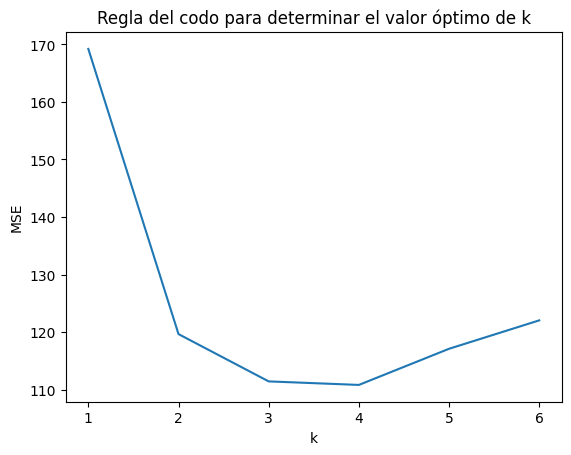

In [133]:
# Lista para almacenar los valores de MSE (Error Cuadrático Medio)
mse = []

# Rango de k para probar
k_range = range(1, 7)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Realizamos la validación cruzada para obtener una medida más robusta del error
    """  estamos tomando el negativo de los valores devueltos para obtener el MSE real. 
         Luego, añadimos la media de estos valores a nuestra lista de MSE para cada valor de k (mse.append(scores.mean())).
    """
    scores = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse.append(scores.mean())
    print(f'scores = {scores}')
    
 
# Graficamos los valores 
plt.plot(k_range, mse)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Regla del codo para determinar el valor óptimo de k')
plt.show()

In [134]:
#Definimos el mejor k:
best_k = k_range[mse.index(min(mse))]

# Creamos el modelo KNN con el mejor valor de k
knn = KNeighborsRegressor(n_neighbors= best_k)

# Ajustamos el modelo a los datos sin valores nulos
knn.fit(X_train, y_train)

# Imputamos los valores faltantes en la columna 'Age'
imputed_ages = knn.predict(df_without_age)
df.loc[df['Age'].isna(), 'Age'] = imputed_ages

## 3. Análisis y visualización de los datos:

### 3.1 Matriz de correlaciones y Heatmap

* Para hacer una matriz de correlaciones y un mapa de calor vamos a tener en cuenta sólo algunas variables ('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'). En el caso de 'Sex' y 'Embarked' tendremos que codificar las variables para asignarles números.

In [157]:
variables=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df['Sex'] = df['Sex'].replace({'male':0, 'female':1})
df['Embarked'] = df['Embarked'].replace({'S':1, 'Q':2, 'C':3})

* En principio, parece que lo que más relación tiene con el estado de la supervivencia es el género ('Sex'), la tarifa ('Fare') y la clase ('Pclass')

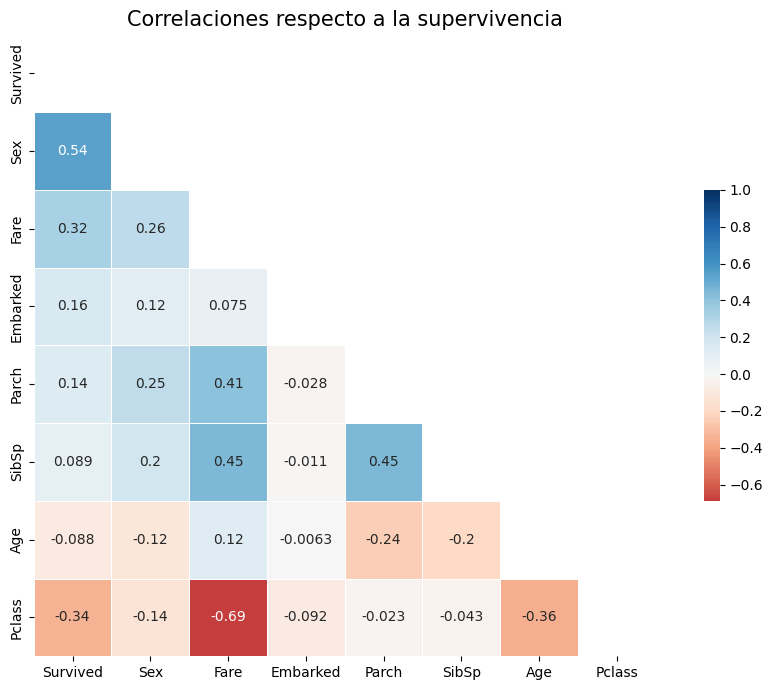

In [159]:
corr = df[variables].corr(method = 'spearman').sort_values(by = 'Survived',  axis = 0, ascending = False).sort_values(by = 'Survived', axis = 1, ascending = False)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,7))
sns.heatmap(corr.iloc[0:8,0:8], mask=mask[0:8,0:8], 
            vmax=1, cmap= 'RdBu', center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True,
            )
plt.title('Correlaciones respecto a la supervivencia', fontsize= 15)
plt.tight_layout()	


### 3.2 Variable 'Age':

* Saber la edad mínima y máxima de las personas del barco.


In [160]:
#Original
minAge_o= round(datos['Age'].min())
maxAge_o = datos['Age'].max()
print(f'La edad mínima es: {minAge_o} \nLa edad máxima es: {maxAge_o}')

La edad mínima es: 0 
La edad máxima es: 80.0


In [161]:
#Después de la imputación
minAge = round(df['Age'].min())
maxAge = df['Age'].max()
print(f'La edad mínima es: {minAge} \nLa edad máxima es: {maxAge}')

La edad mínima es: 0 
La edad máxima es: 80.0


* Conocer la mediana de las edades.


La mediana de la edad con los valores nulos sin corregir:  28.0
La mediana de la edad con valores nulos corregidos:  29.0


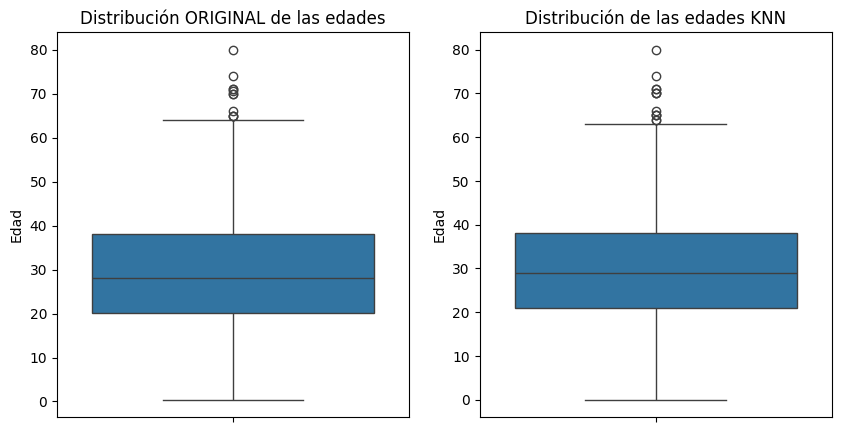

In [139]:
print('La mediana de la edad con los valores nulos sin corregir: ', datos['Age'].median())
print('La mediana de la edad con valores nulos corregidos: ',df['Age'].median())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=datos, y='Age', ax=axs[0])
axs[0].set_title('Distribución ORIGINAL de las edades')
axs[0].set_ylabel('Edad')

sns.boxplot(data=df, y='Age', ax=axs[1])
axs[1].set_title('Distribución de las edades KNN')
axs[1].set_ylabel('Edad');

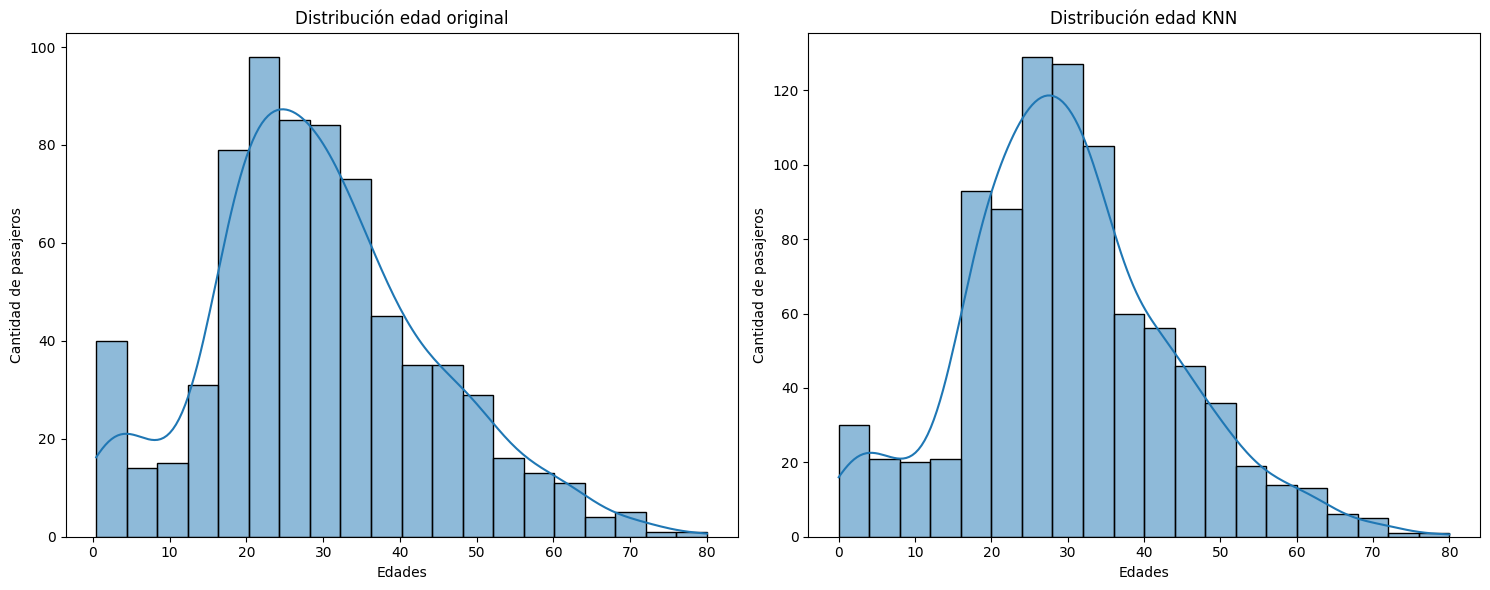

In [140]:
#Distribución de la edad original y corregido:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.histplot(data= datos['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribución edad original')
axes[0].set_ylabel('Cantidad de pasajeros')
axes[0].set_xlabel('Edades')

sns.histplot(data = df['Age'], bins=20, kde =True, ax=axes[1])
axes[1].set_title('Distribución edad KNN')
axes[1].set_ylabel('Cantidad de pasajeros')
axes[1].set_xlabel('Edades')
fig.tight_layout()

* Porcentaje de filas con valores nulos después de corregir los NaN en 'Age'

In [141]:
# Porcentaje de filas con valores nulos.
filas2 = len(df)
filas_null2 = df.isnull().any(axis=1).sum()
filas_sin_null2 = filas - filas_null

porcentajes2 = pd.DataFrame({'Tipo': ['Filas con valores nulos', 'Filas sin valores nulos'],
                               'Cantidad': [filas_null2, filas_sin_null2]}) 


fig2 = px.pie(porcentajes2, names='Tipo', values='Cantidad', title='Filas con NaN después de corregir "Age"',
             width= 700,
             color_discrete_sequence=px.colors.sequential.Blues_r
             )
fig2.show()

In [142]:
# Al comparar con el porcentaje de filas con NaN original se observa que existen grandes cambios.
fig1

### 3.3 Variable Fare

* Ver los precios (columna `Fare`) más altos y bajos.


In [162]:
# Revertiremos la estandarización que se había hecho a la columna Fare:
df['Fare'] = datos['Fare'] #Tomamos los datos originales del 'Fare' del dataframe inicial
print('La tarifa mínima era: ', df['Fare'].min())
print('La tarifa máxima era: ', df['Fare'].max())


La tarifa mínima era:  0.0
La tarifa máxima era:  512.3292


In [163]:
#Porcentaje pagado por las clases del total recaudado:
fig3 = px.pie(df, names = 'Pclass', values='Fare',
       width=500,
       labels = {'Pclass':'Clase','Fare':'Tarifa pagada'},
       title= 'Porcentaje de la tarifa total por clase',
       color_discrete_sequence=px.colors.sequential.Mint_r)
fig3.show()

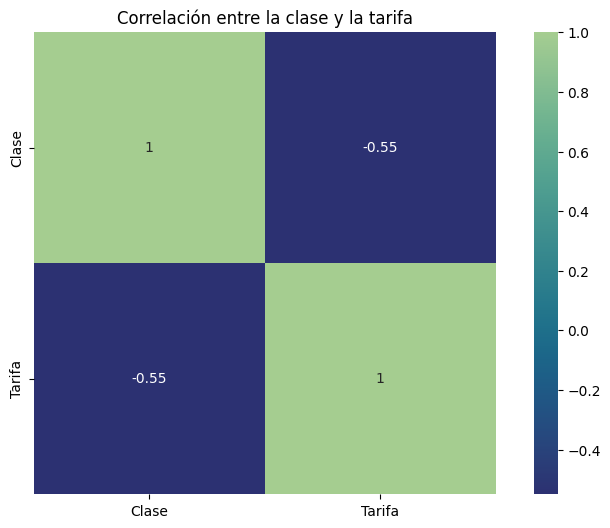

In [164]:
# Correlación entre la clase y la tarifa pagada
corr = df[['Pclass','Fare']].corr()
plt.figure(figsize=(10,6))
map = sns.heatmap(corr, annot=True, square=True, cmap='crest_r')
map.set_title('Correlación entre la clase y la tarifa')
map.set_xticklabels(('Clase','Tarifa'))
map.set_yticklabels(('Clase','Tarifa'));

Una correlación de -0.55 indica sí puede existir una correlación negativa moderada, es decir que mientras una variable disminuye (en este caso el número de la clase), la otra aumenta (en este caso la tarifa).

Hay que tener en cuenta que la clase numérica no corresponde con la clase social. Es decir, la clase numérica 1 (la más baja) corresponde a la primera clase, que socialmente es la más alta. Esto es necesario tenerlo en cuenta para la interpretación de la correlación negativa.

* Distribución de la tarifa pagada por cada pasajero.

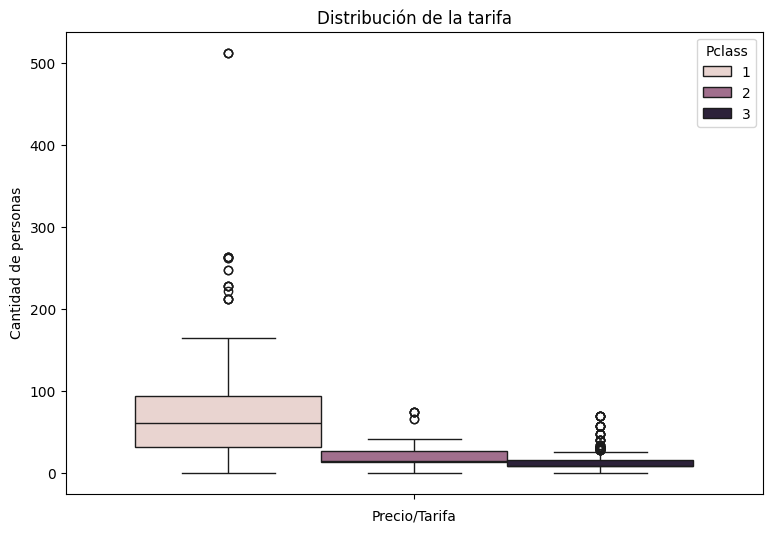

In [187]:
plt.figure(figsize=(9,6))
sns.boxplot(data = df, y='Fare', hue='Pclass')
plt.title('Distribución de la tarifa')
plt.xlabel('Precio/Tarifa')
plt.ylabel('Cantidad de personas');

## 4. Estudio de los supervivientes

### 4.1 Número de pasajeros embarcados (columna `Embarked`).


In [175]:
df['Embarked']=datos['Embarked']

In [177]:
puerto = df['Embarked'].value_counts().reset_index()
fig = px.bar(puerto, y='Embarked', x='index', labels={'index':'Puerto','Embarked':'Cantidad de pasajeros'},
       width=600, title= 'Cantidad de pasajeros embarcados en cada puerto')
fig.update_xaxes(tickvals=['S', 'C', 'Q'], 
             ticktext=['Southampton', 'Cherbourg', 'Queenstown'])
fig.show()


* Ver la distribución de sexos en las personas embarcadas.

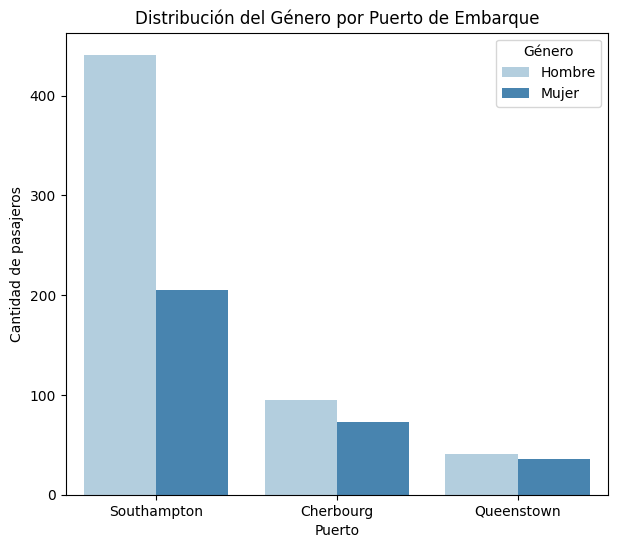

In [178]:
plt.figure(figsize=(7, 6)) 
sns.countplot(x='Embarked', hue='Sex', data=df, palette='Blues')
plt.title('Distribución del Género por Puerto de Embarque')
plt.xlabel('Puerto')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(ticks=['S','C','Q'], labels=['Southampton', 'Cherbourg', 'Queenstown'])
plt.legend(title='Género', labels=['Hombre', 'Mujer'])
plt.show()

### 4.2 Distribución de supervivientes por género

In [179]:
df['Sex'] = datos['Sex']

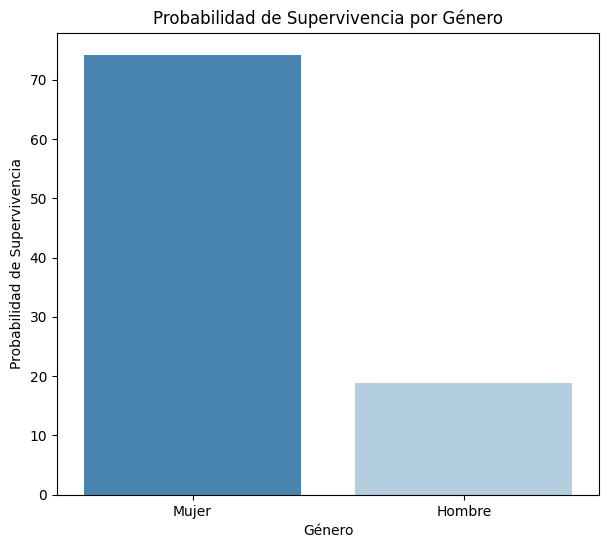

In [180]:
# Total de pasajeros por grupo de edad
total_genero = df.groupby('Sex', observed=False)['Survived'].count()

# Total de supervivientes por grupo de edad
supervivientes_genero = df.groupby('Sex', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_genero = (supervivientes_genero / total_genero)*100

plt.figure(figsize=(7,6))
sns.barplot(x=probabilidad_genero.index, y=probabilidad_genero.values, palette='Blues_r',
            hue = probabilidad_genero.index, legend= False)
plt.title("Probabilidad de Supervivencia por Género")
plt.xlabel("Género")
plt.ylabel("Probabilidad de Supervivencia")
plt.xticks(ticks=['female','male'], labels=['Mujer', 'Hombre'])
plt.show()

In [181]:
#Probabilidad de supervivencia por género:
round(probabilidad_genero,1)

Sex
female    74.2
male      18.9
Name: Survived, dtype: float64

### 4.3 Supervivientes por clase

* Cantidad de pasajeros por clase

In [183]:
df['Pclass'].value_counts().reset_index()

,index,Pclass
0,3,491
1,1,216
2,2,184


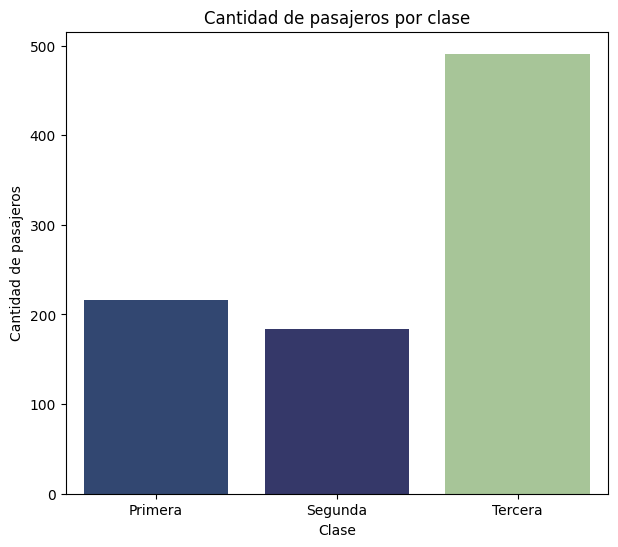

In [184]:
clases = df['Pclass'].value_counts().reset_index()
plt.figure(figsize=(7,6))
sns.barplot(data=clases, x ='index', y='Pclass', palette= 'crest_r',
            hue = 'Pclass',
            legend = False)
plt.title('Cantidad de pasajeros por clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(ticks=['1','2','3'], labels=['Primera', 'Segunda', 'Tercera'])
plt.show()

* Distribución de supervivientes por clase


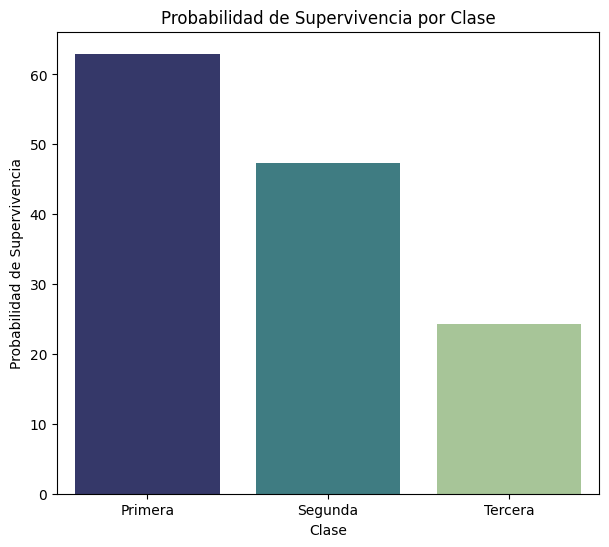

In [ ]:
# Total de pasajeros por grupo de edad
total_por_clase = df.groupby('Pclass', observed=False)['Survived'].count()

# Total de supervivientes por grupo de edad
supervivientes_por_clase = df.groupby('Pclass', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_clase = (supervivientes_por_clase / total_por_clase)*100
plt.figure(figsize=(7,6))
sns.barplot(x=probabilidad_clase.index, y=probabilidad_clase.values, palette='crest_r',
            hue = probabilidad_clase.index, legend= False)
plt.title("Probabilidad de Supervivencia por Clase")
plt.xlabel("Clase")
plt.ylabel("Probabilidad de Supervivencia")
plt.xticks(ticks=['1','2','3'], labels=['Primera', 'Segunda', 'Tercera'])
plt.show()


### 4.4 Supervivencia por edades

* Comparación de la distribución por edad entre el dataset original y imputado por KNN:

In [ ]:
# Se crea una nueva columna con los rangos de edades elegidos para ambos dataframe.
bins = [0, 15, 30, 45, 60, 80]
labels = ['0-15', '16-30', '31-45', '46-60','61-80']

#Se añade la nueva columna de rangos de edad al dataset original y al corregido.
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
datos['AgeGroup'] = pd.cut(datos['Age'], bins=bins, labels=labels, right=False)

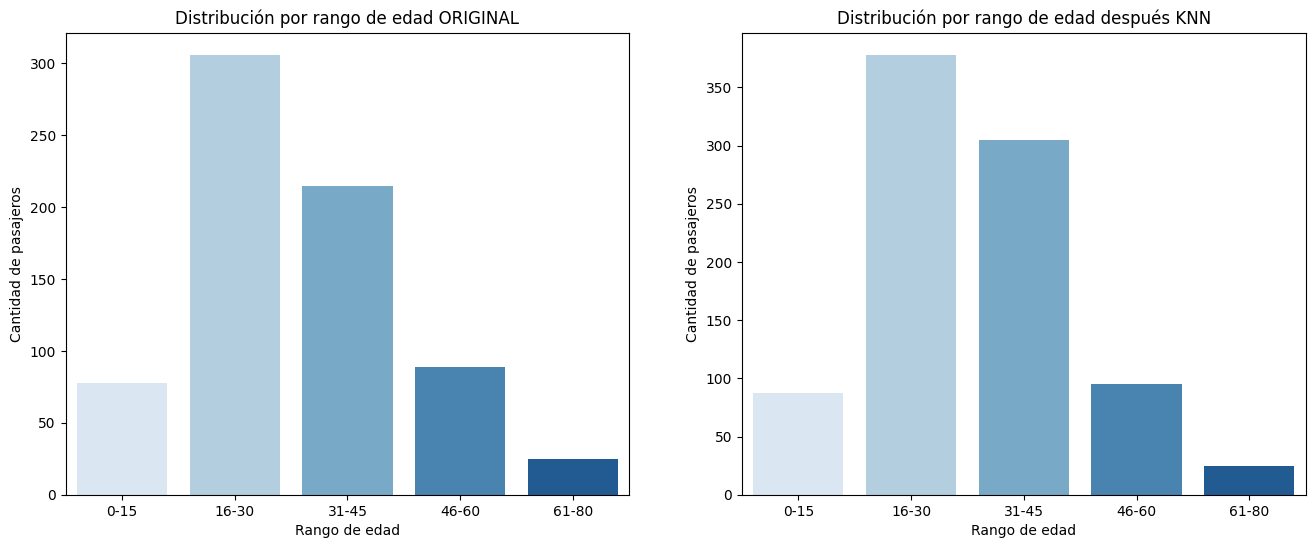

In [ ]:
#Representación gráfica de la distribución de los pasajeros por rango de edad antes y después de la corrección:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(datos['AgeGroup'].value_counts().reset_index(), x='AgeGroup', 
            y = 'count', palette= 'Blues',
            hue = 'AgeGroup', ax=axes[0])
axes[0].set_title('Distribución por rango de edad ORIGINAL')
axes[0].set_xlabel('Rango de edad')
axes[0].set_ylabel('Cantidad de pasajeros')

sns.barplot(df['AgeGroup'].value_counts().reset_index(), x='AgeGroup', 
            y = 'count', palette= 'Blues',
            hue = 'AgeGroup', ax=axes[1])
axes[1].set_title('Distribución por rango de edad después KNN')
axes[1].set_xlabel('Rango de edad')
axes[1].set_ylabel('Cantidad de pasajeros');


* Comparación probabilidad de supervivencia por edad entre Original y KNN:

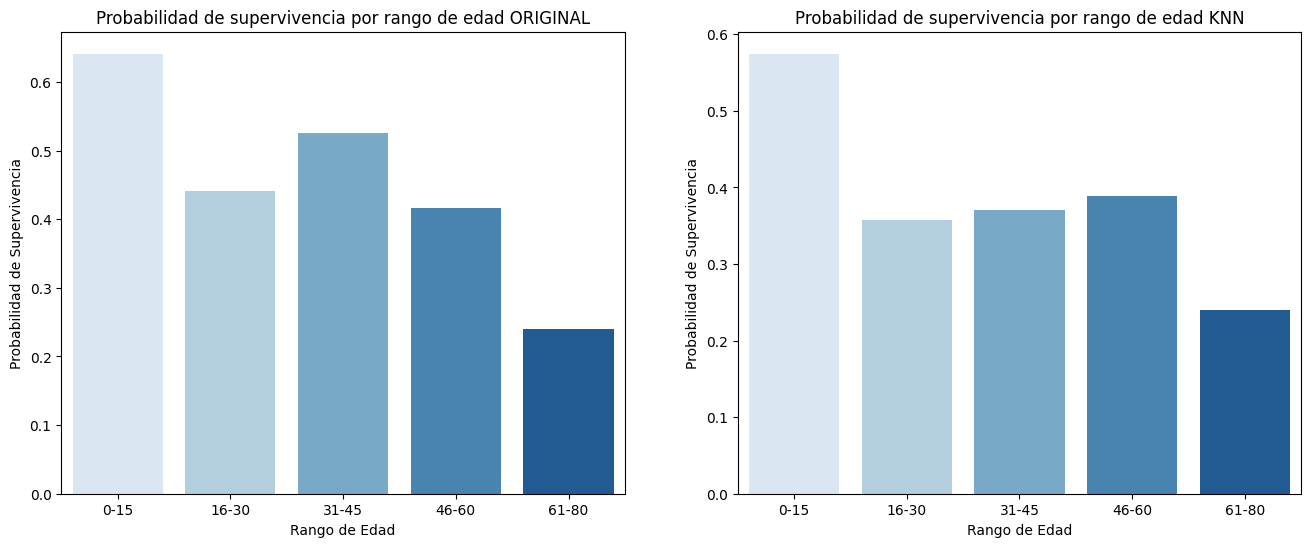

In [ ]:
# Total de pasajeros por grupo de edad
total_por_edad_c= df.groupby('AgeGroup', observed=False)['Survived'].count()
total_por_edad_sc= datos.groupby('AgeGroup', observed=False)['Survived'].count()
# Total de supervivientes por grupo de edad
supervivientes_por_edad_c = df.groupby('AgeGroup', observed=False)['Survived'].sum()
supervivientes_por_edad_sc = df.groupby('AgeGroup', observed=False)['Survived'].sum()

# Probabilidad de supervivencia por grupo de edad
probabilidad_edad_c = supervivientes_por_edad_c / total_por_edad_c
probabilidad_edad_sc = supervivientes_por_edad_sc / total_por_edad_sc

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(x=probabilidad_edad_sc.index, y=probabilidad_edad_sc.values, palette = 'Blues',
            hue = probabilidad_edad_sc.index, ax= axes[0])
axes[0].set_title("Probabilidad de supervivencia por rango de edad ORIGINAL")
axes[0].set_xlabel("Rango de Edad")
axes[0].set_ylabel("Probabilidad de Supervivencia")

sns.barplot(x=probabilidad_edad_c.index, y=probabilidad_edad_c.values, palette = 'Blues',
            hue = probabilidad_edad_c.index, ax= axes[1])
axes[1].set_title("Probabilidad de supervivencia por rango de edad KNN")
axes[1].set_xlabel("Rango de Edad")
axes[1].set_ylabel("Probabilidad de Supervivencia");

## 5. Intento de creación de un modelo de predicción de la supervivencia.

### 5.1 Decisión mejor modelo manual

* En este caso el que mejor F1_score nos ha dado es el random Forest

In [198]:
#Volvemos a codificar la variable 'Sex' y 'Embarked':
df['Sex'] = df['Sex'].replace({'male':0,'female':1})
df['Embarked'] = df['Embarked'].replace({'S':1,'C':2, 'Q':3})

In [200]:
#Elegimos las seis variables que más correlación tienen
variables=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']

In [201]:
X = df[variables]
y = df['Survived']

In [202]:
from sklearn.metrics import classification_report
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA #Análisis de Componentes Principales
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

* Modelo logístico

In [204]:
from sklearn.linear_model import LogisticRegression
# Create an instance of Logistic Regression Classifier and fit the data.
# No pasarse con el número de iteraciones 
logreg = LogisticRegression(max_iter =100)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       110
           1       0.74      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



* KNN

In [208]:
from sklearn.neighbors import KNeighborsClassifier
df['Fare'] = scaler.fit_transform(df[['Fare']])

#Choosing the best K value
weights = 'distance'
p = 2

valores_de_k = list(range(1,31))
grid_de_k = dict(n_neighbors = valores_de_k)
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(weights = weights, p = p)
grid = GridSearchCV(knn, grid_de_k,cv =10, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 20}


In [209]:
from sklearn.neighbors import KNeighborsClassifier
#Parámetros
weights = 'distance'
p = 2
n_neighbours = 20 #Recomendado en la casilla anterior
#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       110
           1       0.63      0.55      0.59        69

    accuracy                           0.70       179
   macro avg       0.69      0.68      0.68       179
weighted avg       0.70      0.70      0.70       179



* Naive Bayes

In [210]:
#Importamos el modelo 
from sklearn.naive_bayes import GaussianNB

#Instanciamos el modelo
classifier = GaussianNB()

#Entrenamos el modelo
classifier.fit(X_train, y_train)

#Predicciones e informe
y_pred = classifier.predict(X_test)
print(y_test-y_pred)
print(classification_report(y_test, y_pred))

565    0
160    0
553    1
860    0
241    0
      ..
880    0
91     0
883    0
473    0
637    0
Name: Survived, Length: 179, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       110
           1       0.70      0.68      0.69        69

    accuracy                           0.77       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179



* Arbol de decisión

In [217]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Instanciar el clasificador
DTC = DecisionTreeClassifier()

# Entrenar el modelo
DTC.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_preds = DTC.predict(X_test)

# Convertir las predicciones a enteros, si es necesario
y_preds = [int(x) for x in y_preds]

# Imprimir el informe de clasificación
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.75      0.75      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



* Random Forest

In [218]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



* Curva ROC

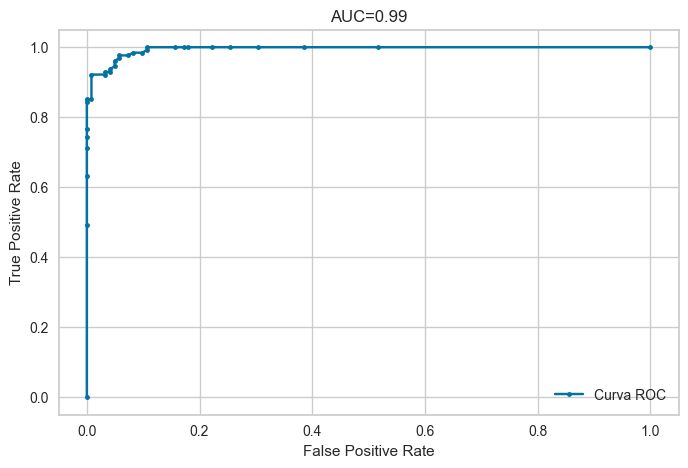

In [220]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#Generamos datos
X, y = make_classification(n_samples = 1000, n_features = 5, n_classes = 2)
#Dividimos en datos de entreno y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
#Entrenamos el modelo
model = RandomForestClassifier().fit(X_train, y_train)
#Elaboramos predicciones sobre los datos de validación
y_pred = model.predict_proba(X_test)[:,1]
#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)
# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()

### 5.2 Decisión de modelo automática con Pycaret

In [226]:
from pycaret.classification import *

#Nos prepara un entorno donde el objetivo es la columna 'Survived'
clf = setup(data = df, target = 'Survived')

#Evaluar qué modelo funciona mejor:
best_models = compare_models()

,Description,Value
0,Session id,3535
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 14)"
4,Transformed data shape,"(891, 20)"
5,Transformed train set shape,"(623, 20)"
6,Transformed test set shape,"(268, 20)"
7,Numeric features,8
8,Categorical features,5
9,Rows with missing values,77.1%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8091,0.8658,0.6694,0.8034,0.7283,0.5831,0.5905,2.3210
ridge,Ridge Classifier,0.7144,0.0000,0.3685,0.7666,0.4944,0.3300,0.3736,0.1860
et,Extra Trees Classifier,0.6773,0.7647,0.2346,0.7330,0.3529,0.2147,0.2736,0.3620
nb,Naive Bayes,0.6581,0.7404,0.2257,0.6740,0.3312,0.1739,0.2228,0.1830
lda,Linear Discriminant Analysis,0.6260,0.5249,0.0348,0.0800,0.0485,0.0335,0.0389,0.1960
rf,Random Forest Classifier,0.6244,0.7797,0.0458,0.5417,0.0830,0.0362,0.0820,0.4030
dt,Decision Tree Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2180
ada,Ada Boost Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1810
gbc,Gradient Boosting Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3160
lightgbm,Light Gradient Boosting Machine,0.6164,0.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.2820


In [227]:
# Elegimos el modelo huber porque es el que tiene más casillas en amarillo
model_lr = create_model('lr')

# Evaluamos qué hiperparámetros son los más adecuados
tunedlr = tune_model(model_lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7302,0.7457,0.5417,0.6842,0.6047,0.4040,0.4104
1,0.8095,0.8590,0.6250,0.8333,0.7143,0.5758,0.5892
2,0.8413,0.9113,0.7500,0.8182,0.7826,0.6580,0.6595
3,0.8226,0.8573,0.6522,0.8333,0.7317,0.6021,0.6122
4,0.8387,0.8904,0.6250,0.9375,0.7500,0.6379,0.6664
5,0.8065,0.8805,0.7083,0.7727,0.7391,0.5857,0.5871
6,0.8065,0.8410,0.7083,0.7727,0.7391,0.5857,0.5871
7,0.8065,0.8805,0.6667,0.8000,0.7273,0.5792,0.5850
8,0.8226,0.9134,0.7083,0.8095,0.7556,0.6173,0.6207


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7460,0.7436,0.5417,0.7222,0.6190,0.4343,0.4445
1,0.8095,0.8665,0.5833,0.8750,0.7000,0.5685,0.5936
2,0.8571,0.9060,0.7917,0.8261,0.8085,0.6947,0.6951
3,0.8387,0.8540,0.6522,0.8824,0.7500,0.6349,0.6507
4,0.8387,0.8860,0.6250,0.9375,0.7500,0.6379,0.6664
5,0.8226,0.8651,0.7083,0.8095,0.7556,0.6173,0.6207
6,0.8065,0.8311,0.7083,0.7727,0.7391,0.5857,0.5871
7,0.8226,0.8783,0.6250,0.8824,0.7317,0.6049,0.6249
8,0.8065,0.9046,0.7083,0.7727,0.7391,0.5857,0.5871


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [228]:
# Evaluamos nuestro modelo tuneado
evaluate_model(tunedlr)

predictions = predict_model(tunedlr)

modelo_final = finalize_model(tunedlr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8246,0.8849,0.6602,0.8500,0.7432,0.6132,0.6245


In [229]:
save_model(modelo_final, 'modeloTitanic')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['PassengerId', 'Pclass', 'Sex',
                                              'Age', 'SibSp', 'Parch', 'Fare',
                                              'Embarked'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_im...
                                      